In [44]:
import torch
import torchvision.models as models
from torchvision.transforms import transforms
import torch.nn as nn
import torch.nn.functional as F
import cv2 as cv
import os
import json
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [26]:
vgg = models.vgg16(weights="DEFAULT")
vgg.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vgg.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [123]:
with open('imagenet-simple-labels.json', 'r') as f:
            class_names = json.load(f)


pretransform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize_transform = transforms.Normalize(mean=mean, std=std) 

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [135]:
def predict(model,transform,img_path,transformed = False):
    if not transformed:
        img = Image.open(img_path).convert("RGB")
        input_tensor = transform(img)
        input_batch = input_tensor.unsqueeze(0)
    else:
        input_batch = img_path.unsqueeze(0)
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
    with torch.no_grad():
        output = model(input_batch)

    _,predicted_idx = torch.max(output,1)

    predicted_class = class_names[predicted_idx.item()]
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    predicted_probability = probabilities[predicted_idx.item()].item()
    print(f"Predicted class: {predicted_class}")
    print(f"Probability: {predicted_probability:.4f}")
    return predicted_idx.item()


Predicted class: sea snake
Probability: 0.4808


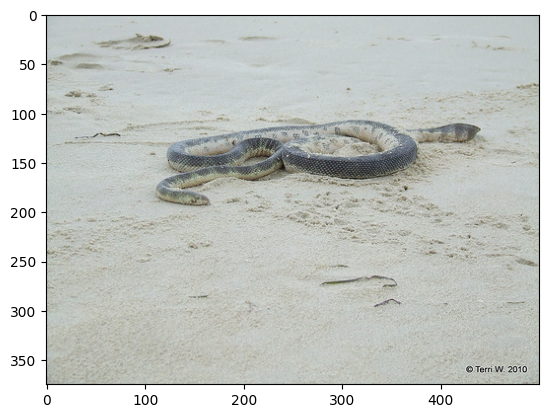

In [82]:
target_idx = predict(vgg,transform,"ILSVRC2012_val_00000001.JPEG")
plt.figure()
img = Image.open("ILSVRC2012_val_00000001.JPEG").convert("RGB")
plt.imshow(img)

In [66]:
def fgsm(image, label, model, loss_fn):
    #Fast Gradient sign methord to generate adversarial images
    input_tensor = transform(image)
    input_img = input_tensor.unsqueeze(0)
    if torch.cuda.is_available():
        input_img = input_img.to('cuda')
    input_img.requires_grad_(True)
    prediction = model(input_img)

    if not isinstance(label, torch.Tensor):
        label = torch.tensor([label], dtype=torch.long, device=device)
    elif label.ndim == 0:
        label = label.unsqueeze(0).to(device)
    else:
        label = label.to(device)
    
    loss = loss_fn(prediction,label)
    grad = torch.autograd.grad(loss, input_img)[0]
    signed_grad = torch.sign(grad) 
    return signed_grad.cpu()

In [50]:
loss_fn = nn.CrossEntropyLoss()

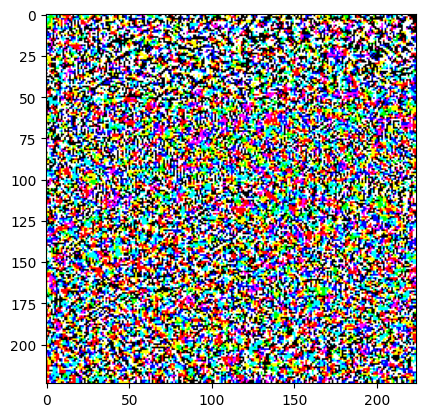

In [114]:
perturbations  = fgsm(img,target_idx,vgg,loss_fn)
perturbation_tensor = perturbations[0]
perturbation_permuted = perturbation_tensor.permute(1, 2, 0)
perturbation_numpy = perturbation_permuted.numpy()
plt.imshow(perturbation_numpy * 0.5 + 0.5)

Predicted class: African rock python
Probability: 0.4571


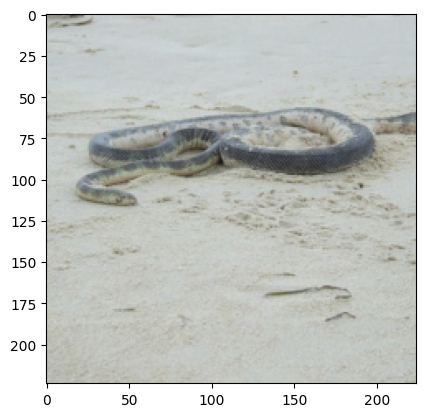

In [150]:
epsilons = [0.001]
for eps in epsilons:
    adv_x = pretransform(img)+eps*perturbations[0]
    adv_x_permuted = adv_x.permute(1,2,0)
    predict(vgg,transform,normalize_transform(adv_x),True)
    plt.imshow(adv_x_permuted)